# MMM - v1

In this notebook, a core procedures to create a MMM - v1 by wrapping `orbit-ml` modules will be demonstrated. Sections include:

1. Libraries And Environment Check
2. Data Cleaning
3. Modeling
- Baseline Model
- Calibrate Priors Model [Optional]

## Library

In [2]:
# import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import torch
# from copy import deepcopy

# import orbit

import karpiu
from karpiu.models import MMM
# from karpiu.utils import insert_events

pd.set_option('display.float_format', lambda x: '%.5f' % x)
# np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 50)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# print(orbit.__version__)
# print(pd.__version__)
# print(np.__version__)
# print(matplotlib.__version__)
# print(torch.__version__)

## Data

In [5]:
RAW_DATA_FILE = 'data.csv'
df = pd.read_csv(RAW_DATA_FILE, parse_dates=['date'])
# df.head(5)
# print(df.dtypes)

In [6]:
adstock_df = pd.read_csv('./adstock.csv')
adstock_df = adstock_df.sort_values(by=['regressor'])
adstock_df = adstock_df.set_index('regressor')
# print(adstock_df.shape)
paid_channels = ['tv', 'radio', 'social', 'promo', 'search']

## Baseline Model

In [7]:
mmm = MMM(
    kpi_col='sales',
    date_col='date', 
    spend_cols=paid_channels,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

INFO:karpiu-mmm:Initialize model


You can obtain best smoothing params in the first run. In the future, you can directly use `set_hyper_params` to skip the tuning process.

In [8]:
mmm.optim_hyper_params(df)
mmm.best_params

INFO:karpiu-mmm:Optimize smoothing params. Only events and seasonality are involved.
INFO:karpiu-mmm:Pre-process data.


  0%|          | 0/75 [00:00<?, ?it/s]

INFO:karpiu-mmm:Best params damped_factor set as 0.95
INFO:karpiu-mmm:Best params seasonality_sm_input set as 0.005946217356472094
INFO:karpiu-mmm:Best params slope_sm_input set as 0.09301448921066349


{'damped_factor': 0.95,
 'seasonality_sm_input': 0.005946217356472094,
 'slope_sm_input': 0.09301448921066349}

Users can access optimization result by `.tuning_df`.

In [9]:
# check optimization result
print(mmm.tuning_df.shape)
mmm.tuning_df.sample(5)

(75, 4)


,damped_factor,seasonality_sm_input,slope_sm_input,metrics
11,0.70000,0.02352,0.00595,15861.55538
65,0.95000,0.09301,0.00150,15760.59838
52,0.95000,0.00150,0.02352,15796.85800
43,0.80000,0.09301,0.09301,15655.65097
34,0.80000,0.00595,0.36788,15675.26904


### Fitting model

Fit the model with supplied dataframe.

In [10]:
mmm.fit(df)

INFO:karpiu-mmm:Fit final model.
INFO:karpiu-mmm:Pre-process data.
INFO:karpiu-mmm:Build regression scheme
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2000 and samples(per chain): 1000.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Extracting Insights

In [11]:
from karpiu.explainer import Attributor

In [12]:
ATTR_START = '2019-03-01'
ATTR_END = '2019-03-31'
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

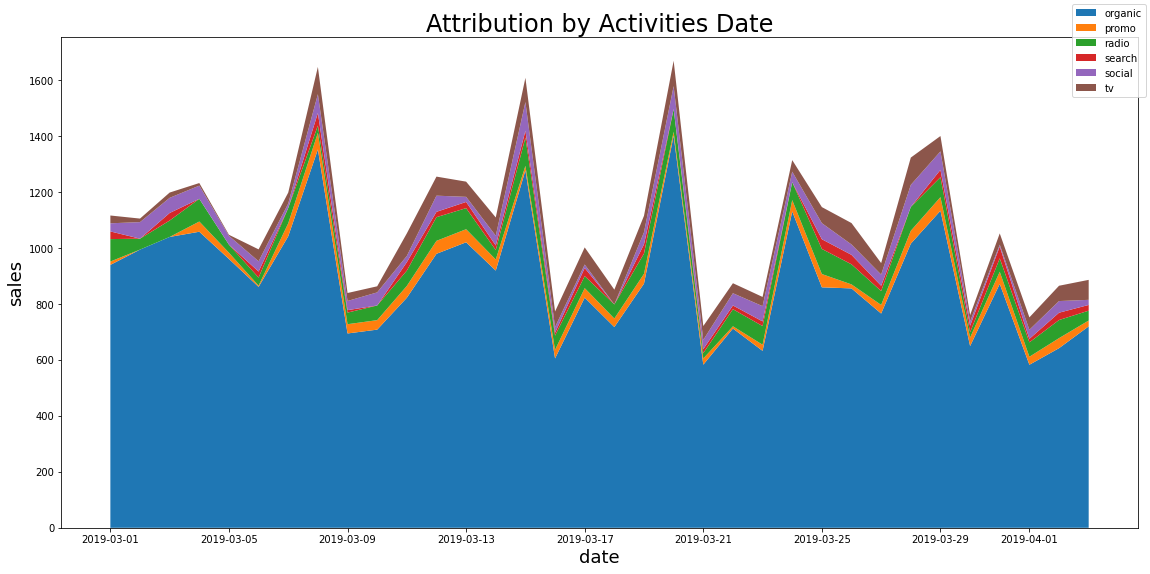

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df['date'].values, 
    activities_attr_df[['organic'] + paid_channels].values.transpose(), 
    labels=['organic'] + paid_channels
)
ax.set_title("Attribution by Activities Date", fontdict={'fontsize': 24})
ax.set_xlabel("date", fontdict={'fontsize': 18})
ax.set_ylabel("sales", fontdict={'fontsize': 18})
fig.legend()
fig.tight_layout();